Iteration 1: norm_delta = 0.66384, step_size = 0.9500, log_lik = -1663.17959, newton_decrement = 46.04648, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.03630, step_size = 0.9500, log_lik = -1620.53093, newton_decrement = 0.19362, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00176, step_size = 0.9500, log_lik = -1620.33817, newton_decrement = 0.00043, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1620.33774, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.
                            coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                               
AGE                     0.019975   1.020175  0.055896       -0.089580   
SEX                     0.027013   1.027381  0.106745       -0.182203   
CompositeStage          0.531571   1.701603  0.061434        0.411162   
LNInvolment            -0.275748   0.759004  0.053051       -0.379

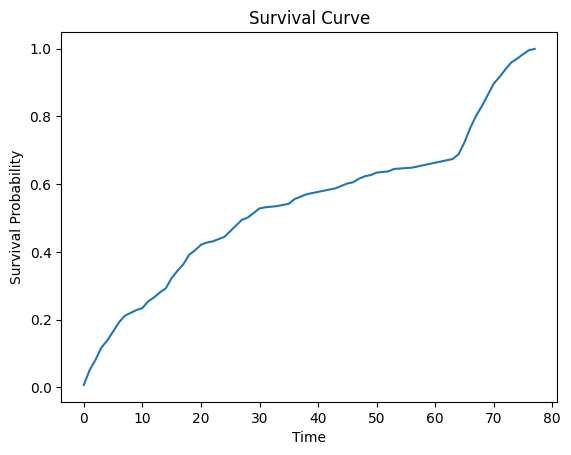

In [30]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = pd.read_excel('data1.xlsx') # Load the data from the .xlsx file

# Preprocess the data: Drop any rows with missing values in the columns of interest
data = data.dropna(subset=['Months', 'DEATH', 'AGE', 'SEX', 'CompositeStage', 'LNInvolment', 'Comorbidity', 'FamiliyHistoryOfCancer'])

# Handle missing values in other columns
imputer = SimpleImputer(strategy='median')
data[['DEATH', 'AGE', 'CompositeStage', 'LNInvolment', 'Comorbidity']] = imputer.fit_transform(data[['DEATH', 'AGE', 'CompositeStage', 'LNInvolment', 'Comorbidity']])

# Standardize the covariates
scaler = StandardScaler()
data[['DEATH', 'AGE', 'CompositeStage', 'LNInvolment', 'Comorbidity']] = scaler.fit_transform(data[['DEATH', 'AGE', 'CompositeStage', 'LNInvolment', 'Comorbidity']])

# Create a new DataFrame with the required columns for the Buckley-James estimator
buckley_james_data = data[['Months', 'DEATH', 'AGE', 'SEX', 'CompositeStage', 'LNInvolment', 'Comorbidity', 'FamiliyHistoryOfCancer']]

# Fit the Buckley-James model with custom options
cph = CoxPHFitter(penalizer=0.1)  # Set the penalizer parameter to control overfitting
cph.fit(buckley_james_data, 'Months', 'DEATH', show_progress=True)  # Set the step_size parameter to control the convergence speed

# Print the estimated coefficients (summary)
print(cph.summary)

# Access other properties of the fitted model (e.g., hazard ratios, p-values)
# For example, to get the hazard ratios:
print(cph.hazard_ratios_)

# Calculate AIC and BIC
n = len(buckley_james_data)
llf = cph.log_likelihood_
k = cph.params_.shape[0]
aic = -2 * llf + 2 * k
bic = -2 * llf + k * np.log(n)

# Print AIC and BIC
print("AIC:", aic)
print("BIC:", bic)

# Make predictions using the fitted model
# For example, to predict the survival probability at a specific time point for a new patient:
new_patient_data = pd.DataFrame({'AGE': [90], 'SEX': [1], 'CompositeStage': [2], 'LNInvolment': [1], 'Comorbidity': [0], 'FamiliyHistoryOfCancer': [0]})
partial_hazard = cph.predict_partial_hazard(new_patient_data)
survival_prob = 1 - cph.baseline_survival_

# Plot the survival curve
plt.plot(cph.baseline_survival_.index, survival_prob.values)
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curve')
plt.show()

# Perform other analyses or visualizations as needed
